In this notebook we cluster a subset measured target spectra for each species and used to cluster centers to classify the remaining data

In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import feature
from yellowbrick.cluster.elbow import kelbow_visualizer

import sys, errno  


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [3]:

palette = sns.color_palette('Paired', n_colors=14)
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [4]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/'


# Read saved df

In [5]:
a_df = pd.read_feather(apath+'/a_tilt_df.feather')
p_df = pd.read_feather(ppath+'/p_tilt_df.feather')
p2_df = pd.read_feather(p2path+'/p2_tilt_df.feather')


# Cluster spectra
sort by frequency bandwith

In [6]:
np.all(np.isnan(a_df['94.000']))

False

In [7]:
def select_ts_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(np.isnan(df['200.000']))[0]
    ts_s_120 = np.where(df.columns.values=='94.000')[0][0]
    ts_e_120 = np.where(df.columns.values=='160.000')[0][0]
    
    ind_200 = np.where(np.isnan(df['120.000']))[0]
    ts_s_200 = np.where(df.columns.values=='189.000')[0][0]
    ts_e_200 = np.where(df.columns.values=='251.000')[0][0]

    df_120 = df.iloc[ind_120,ts_s_120:ts_e_120]
    df_200 = df.iloc[ind_200,ts_s_200:ts_e_200]
    
    return df_120, df_200

In [8]:
a_df_120, a_df_200 = select_ts_bandwidth(a_df)
p_df_120, p_df_200 = select_ts_bandwidth(p_df)
p2_df_120, p2_df_200 = select_ts_bandwidth(p2_df)

## Train kmeans on subset

In [9]:
def select_sample(df, sample_size=1500):
    "splits dataframe intro training and testing sections"
    df_train = df.sample(sample_size)
    df_test = df.iloc[~df.index.isin(df_train.index)]
    
    return df_train, df_test

In [10]:
a_120_df_train, a_120_df_test = select_sample(a_df_120)
p_120_df_train, p_120_df_test = select_sample(p_df_120)
p2_120_df_train, p2_120_df_test = select_sample(p2_df_120)

a_200_df_train, a_200_df_test = select_sample(a_df_200)
p_200_df_train, p_200_df_test = select_sample(p_df_200)
p2_200_df_train, p2_200_df_test = select_sample(p2_df_200)

In [11]:
def kmean_spectra(df, num_clus=6):
    'Function to run kmean clusering on target spectra of a species'
    # Set up kmeans
    kmeans = KMeans(n_clusters=num_clus)
    
    # Normalize by the median of each target spectra
    df_norm = df.div(df.median(axis=1), axis=0)
    
    # Fit data
    y_kmean = kmeans.fit_predict(df_norm)

    return y_kmean, kmeans
    

In [12]:
num_clus=4
a_120_ykmean, a_120_kmean = kmean_spectra(a_120_df_train, num_clus=num_clus)
p_120_ykmean, p_120_kmean = kmean_spectra(p_120_df_train, num_clus=num_clus)
p2_120_ykmean, p2_120_kmean = kmean_spectra(p2_120_df_train, num_clus=num_clus)


a_200_ykmean, a_200_kmean = kmean_spectra(a_200_df_train, num_clus=num_clus)
p_200_ykmean, p_200_kmean = kmean_spectra(p_200_df_train, num_clus=num_clus)
p2_200_ykmean, p2_20_kmean = kmean_spectra(p2_200_df_train, num_clus=num_clus)

C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

In [32]:
# Add kmeans group to main dataframe
def add_ykmean(df, y_120, y_200, df_f120, df_f200, num_clus=4):
    y_120 = pd.DataFrame(y_120, index=df_f120.index, columns=['y_kmean'])
    y_200 = pd.DataFrame(y_200+num_clus, index=df_f200.index, columns=['y_kmean'])
    y = pd.concat([y_120,y_200])
    df['y_kmean']=y
    df['abs_tilt'] = np.abs(df['tilt'])
    return df

In [33]:
a_120_ykmean

array([1, 3, 2, ..., 2, 2, 0])

In [34]:
a_120_df_train.index

Int64Index([2896, 5050, 1160, 3727,  429, 2516, 5142,  748,   46, 4579,
            ...
            3300,  993, 3185,  766, 2750, 1587, 2155,  254, 3718, 5500],
           dtype='int64', length=1500)

In [35]:
a_df = add_ykmean(a_df, a_120_ykmean, a_200_ykmean, a_120_df_train, a_200_df_train, num_clus=num_clus)
p_df = add_ykmean(p_df, p_120_ykmean, p_200_ykmean, p_120_df_train, p_200_df_train, num_clus=num_clus)
p2_df = add_ykmean(p2_df, p2_120_ykmean, p2_200_ykmean, p2_120_df_train, p2_200_df_train, num_clus=num_clus)

In [36]:
a_df

,index,Ping_number,Target_range,Depth,Region_name,90.000,90.500,91.000,91.500,92.000,...,Angle_major_axis,TS_comp,z,x,y,tilt,alpha,off_axis_dist,y_kmean,abs_tilt
0,0,4,4.175998,4.172158,Region 1,NaN,NaN,NaN,NaN,NaN,...,0.32827,-34.851123,-4.172158,0.177462,-0.023904,NaN,-16.158324,0.179065,NaN,NaN
1,1,6,4.286814,4.279987,Region 1,NaN,NaN,NaN,NaN,NaN,...,-2.90870,-37.269647,-4.279987,-0.105811,0.217466,-18.640175,-21.122026,0.241842,NaN,18.640175
2,2,7,4.339306,4.333609,Region 1,NaN,NaN,NaN,NaN,NaN,...,-2.90370,-36.833249,-4.333609,0.032976,0.219812,2.219360,25.560746,0.222271,NaN,2.219360
3,3,8,4.117674,4.109046,Region 1,NaN,NaN,NaN,NaN,NaN,...,3.39490,-49.366760,-4.109047,0.107527,-0.243755,14.136476,2.712206,0.266418,NaN,14.136476
4,4,9,4.111842,4.095177,Region 1,NaN,NaN,NaN,NaN,NaN,...,4.56170,-49.747903,-4.095177,-0.173235,-0.326735,NaN,NaN,0.369819,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5510,597,6269,4.765071,4.754370,Region 99,NaN,NaN,NaN,NaN,NaN,...,3.16360,-29.984493,-4.754370,-0.181140,-0.262781,-42.064309,-13.956613,0.319164,5.0,42.064309
5511,598,6270,4.829227,4.828488,Region 99,NaN,NaN,NaN,NaN,NaN,...,0.83496,-35.507242,-4.828488,0.046723,-0.070370,-9.535037,-5.113461,0.084469,NaN,9.535037
5512,599,6271,4.858389,4.848602,Region 99,NaN,NaN,NaN,NaN,NaN,...,3.26970,-35.681422,-4.848602,0.135197,-0.276996,-4.552331,-3.991202,0.308229,7.0,4.552331
5513,600,6272,4.893384,4.884509,Region 99,NaN,NaN,NaN,NaN,NaN,...,-2.76610,-33.848678,-4.884509,0.176290,0.235996,-2.219164,-0.447125,0.294571,0.0,2.219164


In [30]:
# save_pca_df PCA columns
def save_pca_df(df, nom_freq, spec, y_kmean):
    if nom_freq == 200:
        ind_freq = np.where(np.isnan(df['120.000']))[0]
    else :
        ind_freq = np.where(np.isnan(df['200.000']))[0]    

    freqselect_df = df.iloc[ind_freq]
    pca_df = freqselect_df[['y_kmean','Target_range','alpha','tilt','off_axis_dist']]

    
    pca_df = pca_df.reset_index(drop=True)
    pca_df = pca_df[~np.isnan(pca_df['tilt'])]
    
    pca_df.to_feather(spec+'%.0fpca.feather' %nom_freq)

### Plot kmeans clustering results

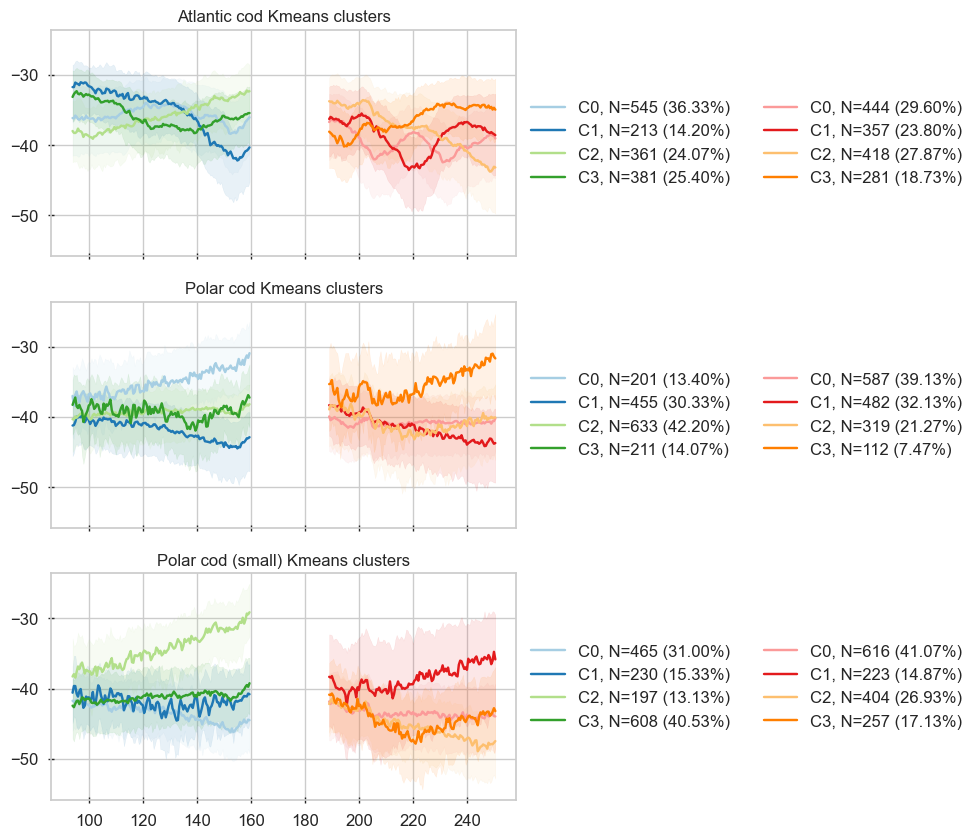

In [17]:
df_list = [a_120_df_train,p_120_df_train,p2_120_df_train]
y_list = [a_120_ykmean, p_120_ykmean, p2_120_ykmean]
df2_list = [a_200_df_train,p_200_df_train,p2_200_df_train]
y2_list = [a_200_ykmean, p_200_ykmean, p2_200_ykmean]
    
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod (small)']
fig,ax = plt.subplots(3,1, figsize=(6,10), sharex=True, sharey=True)
axes = ax.flatten()

for i_df in range(len(df_list)):
    # 120 kHz
    df1 = df_list[i_df]
    y_kmean1 = y_list[i_df]
    freqs_120 = df1.columns.unique().values.astype(np.float64)

    for i_cluster in range(num_clus):
        i_ts1 = np.where(y_kmean1==i_cluster)[0]
        N1 = len(i_ts1)
        
        axes[i_df].plot(freqs_120,np.median(df1.iloc[i_ts1,:].T,axis=1), c=palette[i_cluster], label=f'C{i_cluster}, N={N1} ({N1*100/len(df1):.2f}%)')
        axes[i_df].fill_between(freqs_120,df1.iloc[i_ts1,:].quantile(q=0.25), df1.iloc[i_ts1,:].quantile(q=0.75), color=palette[i_cluster], alpha=0.1)
        
        
    # 200 kHz
    df2 = df2_list[i_df]
    y_kmean2 = y2_list[i_df]
    freqs_200 = df2.columns.unique().values.astype(np.float64)

    for i_cluster in range(num_clus):
        i_ts2 = np.where(y_kmean2==i_cluster)[0]
        N2 = len(i_ts2) 

        axes[i_df].plot(freqs_200,np.median(df2.iloc[i_ts2,:].T,axis=1), c=palette[i_cluster+num_clus], label=f'C{i_cluster}, N={N2} ({N2*100/len(df2):.2f}%)')
        axes[i_df].fill_between(freqs_200,df2.iloc[i_ts2,:].quantile(q=0.25), df2.iloc[i_ts2,:].quantile(q=0.75), color=palette[i_cluster+num_clus], alpha=0.1)
        
    axes[i_df].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    axes[i_df].set_title(f'{name_list[i_df]} Kmeans clusters')


Observations:
- clusters are less well developed (evenly distirbuted?) than with full spectrum, especially for polar cod

# Predict for test data


For each frequency band, combine centers for Atlantic cod and polar cod (1 of the 2 iterations)

In [18]:
cluster_centers = np.concatenate([a_120_kmean.cluster_centers_,p2_120_kmean.cluster_centers_], axis=0)

In [19]:
def kmean_predict(df, clus_center,num_clus=5):
    'Function to run kmean clusering on target spectra of a species'
    # Set up kmeans
    kmeans_cod = KMeans(n_clusters=num_clus*2, init = clus_center, n_init=1)
    kmeans_cod.fit(clus_center)
    
    # Normalize by the median of each target spectra
    df_norm = df.div(df.median(axis=1), axis=0)
    
    # Fit data
    y_kmean = kmeans_cod.predict(df_norm)

    return y_kmean

In [20]:
test_both = pd.concat([a_120_df_test,p_120_df_test],axis=0)
test_label = np.concatenate([np.zeros(len(a_120_df_test)),np.ones(len(p_120_df_test))])
label_bool = test_label.astype(bool)

In [21]:
y = kmean_predict(test_both,cluster_centers, num_clus=num_clus)

C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


[Text(0.5, 1.0, 'Polar cod cluster labels')]

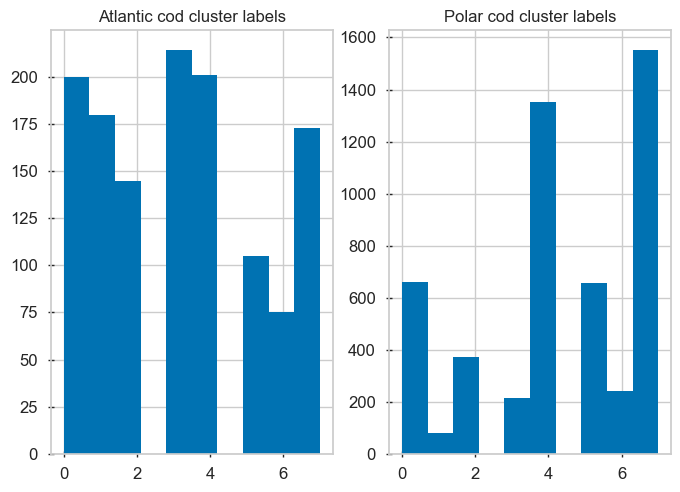

In [22]:
fig,ax = plt.subplots(1,2)
axes = ax.flatten()
axes[0].hist(y[~label_bool])
axes[0].set(title='Atlantic cod cluster labels')
axes[1].hist(y[label_bool])
axes[1].set(title='Polar cod cluster labels')

In [23]:
np.sum(y[label_bool]>num_clus-1)/len(y[label_bool])


0.7412177985948478

In [24]:
np.sum(y[~label_bool]<num_clus)/len(y[~label_bool])

0.57153905645785